In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

In [2]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler, RobustScaler
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns
import random

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
SEED = 565
n_splits = 5
seed_everything(SEED)

# EDA

In [3]:
season_dtype = pl.Enum(['Spring', 'Summer', 'Fall', 'Winter'])

train = (
    pl.read_csv('./train.csv')
    .with_columns(pl.col('^.*Season$').cast(season_dtype))
)

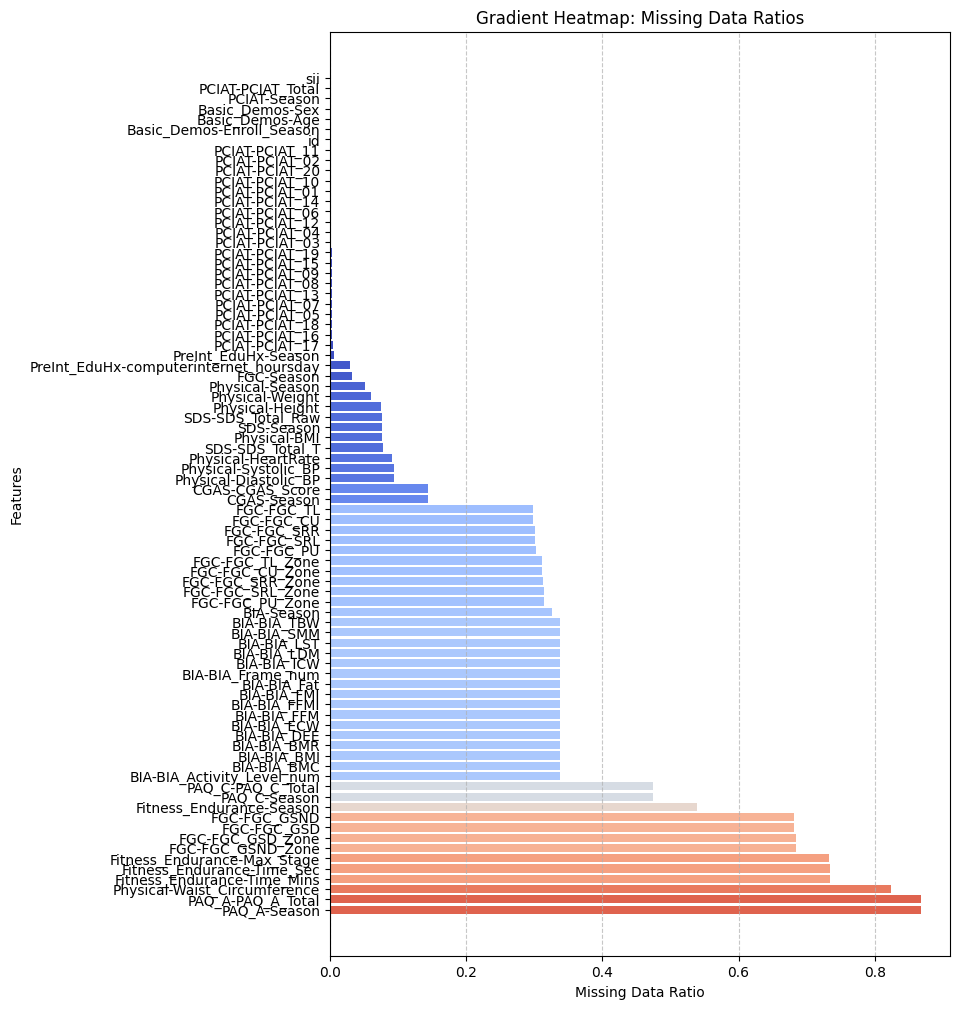

In [4]:
supervised_usable = (
    train
    .filter(pl.col('sii').is_not_null())
)

missing_count = (
    supervised_usable
    .null_count()
    .transpose(include_header=True,
               header_name='feature',
               column_names=['null_count'])
    .sort('null_count', descending=True)
    .with_columns((pl.col('null_count') / len(supervised_usable)).alias('null_ratio'))
)
features = missing_count.get_column("feature")
null_ratios = missing_count.get_column("null_ratio")
plt.figure(figsize=(8, 12))
plt.barh(features, null_ratios, color=plt.cm.coolwarm(null_ratios))
plt.title("Gradient Heatmap: Missing Data Ratios")
plt.xlabel("Missing Data Ratio")
plt.ylabel("Features")
plt.grid(axis='x', linestyle='--', alpha=0.7)
output_plot_path = "./gradient_heatmap.png"
plt.savefig(output_plot_path, bbox_inches='tight')

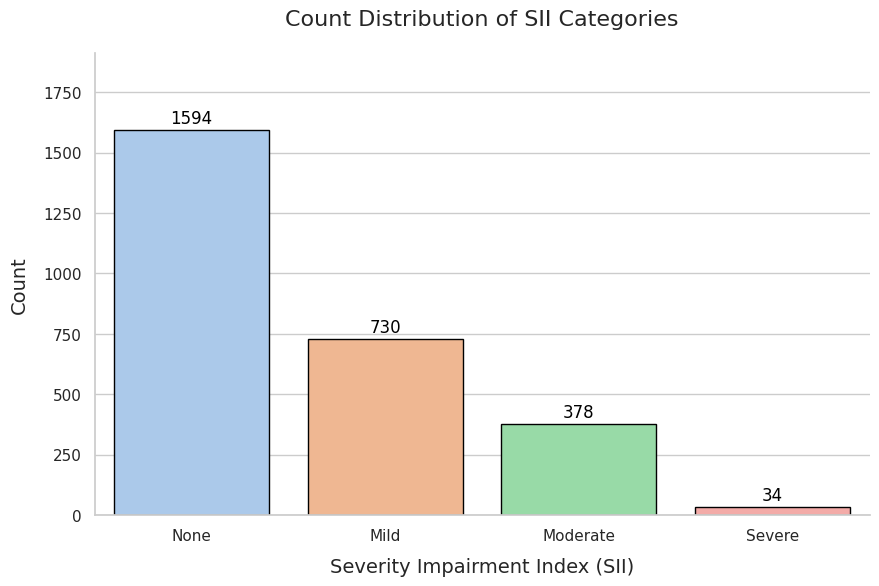

In [5]:
sii_counts = train.filter(pl.col('sii').is_not_null()) \
                  .group_by('sii') \
                  .agg(pl.count()) \
                  .sort('sii')

sii_labels = ["None", "Mild", "Moderate", "Severe"]
sii_values = sii_counts["count"]

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
bars = sns.barplot(x=sii_labels, y=sii_values, palette="pastel", edgecolor="black")

for i, count in enumerate(sii_values):
    plt.text(i, count + 10, f"{count}", ha="center", va="bottom", fontsize=12, color="black")

plt.xlabel("Severity Impairment Index (SII)", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)
plt.title("Count Distribution of SII Categories", fontsize=16, pad=20)

plt.ylim(0, max(sii_values) * 1.2)

sns.despine()

plt.show()

# Feature Engineering

- **Feature Selection**: The dataset contains features related to physical characteristics (e.g., BMI, Height, Weight), behavioral aspects (e.g., internet usage), and fitness data (e.g., endurance time). 
- **Categorical Feature Encoding**: Categorical features are mapped to numerical values using custom mappings for each unique category within the dataset. This ensures compatibility with machine learning algorithms that require numerical input.
- **Time Series Aggregation**: Time series statistics (e.g., mean, standard deviation) from the actigraphy data are computed and merged into the main dataset to create additional features for model training.


In [6]:
from scipy.stats import skew, kurtosis

def compute_time_series_features(df):
    features = {}
    time_series_features = ['X', 'Y', 'Z', 'enmo', 'anglez', 'light']
    
    for col in time_series_features:
        data = df[col].dropna()
        features[f'{col}_mean'] = data.mean()
        features[f'{col}_std'] = data.std()
        features[f'{col}_min'] = data.min()
        features[f'{col}_max'] = data.max()
        features[f'{col}_median'] = data.median()
        features[f'{col}_skew'] = skew(data)
        features[f'{col}_kurtosis'] = kurtosis(data)
        
    non_wear = df['non-wear_flag']
    features['non_wear_total_time'] = non_wear.sum()
    features['non_wear_percentage'] = non_wear.mean() * 100
    features['non_wear_episodes'] = ((non_wear.diff() == 1).sum())
    feature_array = np.array(list(features.values()))
    return feature_array

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return compute_time_series_features(df), filename.split('=')[1]

def load_time_series(dirname):
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df


class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    data_tensor = torch.FloatTensor(df_scaled)
    
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())
    
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')
                 
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded

In [7]:
train = pd.read_csv('./train.csv')
train_ts = load_time_series("./series_train.parquet")

df_train = train_ts.drop('id', axis=1)
missing_percentage = train.isnull().mean()
featuresCols = missing_percentage[missing_percentage < 0.5].index.tolist()
featuresCols = [x for x in featuresCols if ("Season" not in x) and ("PCIAT" not in x)]

train_ts_encoded = perform_autoencoder(df_train, encoding_dim=20, epochs=100, batch_size=32)

time_series_cols = train_ts_encoded.columns.tolist()
train_ts_encoded["id"]=train_ts["id"]

train_ts = train_ts_encoded
train = pd.merge(train, train_ts, how="left", on='id')

# train = feature_engineering(train)

# featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
#                 'CGAS-CGAS_Score', 'Physical-BMI',
#                 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
#                 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
#                 'Fitness_Endurance-Max_Stage',
#                 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
#                 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
#                 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
#                 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
#                 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
#                 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
#                 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
#                 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
#                 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
#                 'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
#                 'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
#                 'SDS-SDS_Total_T',
#                 'PreInt_EduHx-computerinternet_hoursday', 'sii']
                # 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                # 'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                # 'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')
train = train.drop('id', axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 996/996 [00:26<00:00, 37.28it/s]


Epoch [10/100], Loss: 0.1113]
Epoch [20/100], Loss: 0.0649]
Epoch [30/100], Loss: 0.0422]
Epoch [40/100], Loss: 0.0334]
Epoch [50/100], Loss: 0.0256]
Epoch [60/100], Loss: 0.0191]
Epoch [70/100], Loss: 0.0158]
Epoch [80/100], Loss: 0.0122]
Epoch [90/100], Loss: 0.0143]
Epoch [100/100], Loss: 0.0103]


In [8]:
train

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20
0,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,0.0,0.0,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.061430,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,0,NaN,14.035590,48.0,46.0,75.0,70.0,122.0,3.0,0.0,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.211720,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,46.0,64.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,1,71.0,16.648696,56.5,75.6,65.0,94.0,117.0,20.0,1.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,54.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,0,71.0,18.292347,56.0,81.6,60.0,97.0,117.0,18.0,1.0,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.220330,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,31.0,45.0,0.0,1.0,0.644816,-0.213259,-1.213858,-0.759825,0.943994,-0.237984,-0.555701,-0.009070,-0.031160,-0.412570,0.040406,0.804696,0.353851,0.875818,-0.175482,0.445157,-0.826747,0.131077,0.735386,-0.450682
5,13,1,50.0,22.279952,59.5,112.2,60.0,73.0,102.0,12.0,0.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.498800,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,40.0,56.0,0.0,1.0,-0.869838,1.418052,-0.285000,-0.554760,2.011259,-0.942170,2.297571,-0.025737,0.216911,-1.152223,0.536276,-1.005427,-0.853837,0.755042,0.593749,2.361978,1.421222,0.289903,0.523851,-0.240251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,8,0,NaN,17.139810,52.5,67.2,60.0,65.0,112.0,0.0,0.0,0.0,0.0,8.0,1.0,10.0,1.0,12.0,1.0,3.0,3.20303,17.1417,1035.270,1759.96,11.00630,52.5331,13.4004,3.741300,14.66690,1.0,25.7118,15.81500,49.3301,20.2645,36.7181,41.0,58.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3954,7,1,NaN,13.927006,48.5,46.6,65.0,75.0,105.0,0.0,0.0,0.0,0.0,9.0,0.0,8.5,0.0,4.5,0.0,1.0,2.36680,13.6457,966.287,1256.17,9.98802,45.1853,13.2315,0.414263,1.41470,1.0,20.0572,15.14000,42.8185,18.0937,30.0453,48.0,67.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3955,13,0,60.0,16.362460,59.5,82.4,71.0,70.0,104.0,16.0,0.0,10.0,1.0,8.0,1.0,9.0,1.0,12.0,1.0,3.0,4.52277,16.3642,1206.880,2051.70,19.46110,70.8117,14.0629,2.301380,11.58830,1.0,33.3709,17.97970,66.2889,29.7790,52.8320,35.0,50.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3957,11,0,68.0,21.441500,60.0,109.8,79.0,99.0,116.0,15.0,1.0,0.0,0.0,10.0,1.0,10.0,1.0,14.0,1.0,2.0,4.41305,21.4438,1253.740,2005.99,20.48250,75.8033,14.8043,6.639520,33.99670,2.0,33.9805,21.34030,71.3903,28.7792,54.4630,56.0,77.0,0.0,1.0,-0.884151,1.351713,-1.687389,0.301869,1.737385,1.837115,0.623822,-0.414917,-0.205125,-1.045933,0.024950,2.525338,-1.591851,1.267520,-0.883594,1.056547,0.831

In [9]:
if np.any(np.isinf(train)):
    train = train.replace([np.inf, -np.inf], np.nan)

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [10]:
train.head()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii,Enc_1,Enc_2,Enc_3,Enc_4,Enc_5,Enc_6,Enc_7,Enc_8,Enc_9,Enc_10,Enc_11,Enc_12,Enc_13,Enc_14,Enc_15,Enc_16,Enc_17,Enc_18,Enc_19,Enc_20
0,5,0,51.0,16.877316,46.0,50.8,NaN,NaN,NaN,0.0,0.0,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.06143,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,0,NaN,14.035590,48.0,46.0,75.0,70.0,122.0,3.0,0.0,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.21172,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,46.0,64.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,1,71.0,16.648696,56.5,75.6,65.0,94.0,117.0,20.0,1.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,54.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,0,71.0,18.292347,56.0,81.6,60.0,97.0,117.0,18.0,1.0,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.22033,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,31.0,45.0,0.0,1.0,0.644816,-0.213259,-1.213858,-0.759825,0.943994,-0.237984,-0.555701,-0.009070,-0.031160,-0.412570,0.040406,0.804696,0.353851,0.875818,-0.175482,0.445157,-0.826747,0.131077,0.735386,-0.450682
5,13,1,50.0,22.279952,59.5,112.2,60.0,73.0,102.0,12.0,0.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.49880,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,40.0,56.0,0.0,1.0,-0.869838,1.418052,-0.285000,-0.554760,2.011259,-0.942170,2.297571,-0.025737,0.216911,-1.152223,0.536276,-1.005427,-0.853837,0.755042,0.593749,2.361978,1.421222,0.289903,0.523851,-0.240251


### Training and CV

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import joblib

In [12]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import joblib

smote = SMOTE(random_state=SEED)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

rf_params = {
    "n_estimators": 200,
    "max_depth": None,
    "min_samples_split": 2,
    "random_state": SEED
}

lr_params = {
    "penalty": "l1",
    "C": 0.05,
    "solver": "saga"
}

TabNet_Params = {
    'verbose': 0,
    'device_name': 'cuda' if torch.cuda.is_available() else 'cpu'
}

XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': None,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED,
    'tree_method': 'hist',
    'device': 'cuda'
}

LGBM_Params = {
    'learning_rate': 0.046,
    'max_depth': None,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01,  # Increased from 2.68e-06
    'device': 'gpu',
    'verbose': -1
}

CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': None,
    'iterations': 200,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 10,  # Increase this value
    'task_type': 'GPU'
}

X_train = train.drop('sii', axis=1).values
y_train = train['sii']
results = {
    "logistic regression": 0,
    "random forest": 0,
    "catboost": 0
}

results_accuracy = {
    "logistic regression": 0,
    "random forest": 0,
    "catboost": 0
}

results_precision = {
    "logistic regression": 0,
    "random forest": 0,
    "catboost": 0
}

results_recall = {
    "logistic regression": 0,
    "random forest": 0,
    "catboost": 0
}

model_dir = "models_1"
os.makedirs(model_dir, exist_ok=True)
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    # define models
    lr = LogisticRegression(**lr_params)
    rf = RandomForestClassifier(**rf_params)
    tbn = TabNetClassifier(**TabNet_Params)
    xgb = XGBClassifier(**XGB_Params)
    lgbm = LGBMClassifier(**LGBM_Params)
    catboost = CatBoostClassifier(**CatBoost_Params)
    imputer = KNNImputer(n_neighbors=5)

    X_train = imputer.fit_transform(X_train)
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train.values[train_idx], y_train.values[val_idx]

    scaler = StandardScaler()
    # X_train_fold, X_val_fold = scaler.fit_transform(X_train_fold), scaler.fit_transform(X_val_fold)

    inner_SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    inner_train_idx, val_idx = next(inner_SKF.split(X_train_fold, y_train_fold))
    X_train_fold_tabnet, X_val_fold_tabnet = X_train_fold[inner_train_idx], X_train_fold[val_idx]
    y_train_fold_tabnet, y_val_fold_tabnet = y_train_fold[inner_train_idx], y_train_fold[val_idx]
    
    X_train_fold, y_train_fold = smote.fit_resample(X_train_fold, y_train_fold)
    X_train_fold_tabnet, y_train_fold_tabnet = smote.fit_resample(X_train_fold_tabnet, y_train_fold_tabnet)
    
    print("=" * 100)
    print(f"Logistic Regression result for fold: {fold}")
    lr.fit(scaler.fit_transform(X_train_fold), y_train_fold)
    # joblib.dump(lr, f'{model_dir}/lr_fold_{fold}.pkl')
    y_pred_tmp = lr.predict(scaler.fit_transform(X_val_fold))
    qwk = quadratic_weighted_kappa(y_val_fold, y_pred_tmp)
    results["logistic regression"] += qwk
    print(f"QWK: {qwk}")
    print("Classification Report:")
    cls_rpt = classification_report(y_val_fold, y_pred_tmp, output_dict=True)
    print(cls_rpt)
    results_accuracy["logistic regression"] += cls_rpt["accuracy"]
    results_recall["logistic regression"] += cls_rpt["weighted avg"]["recall"]
    results_precision["logistic regression"] += cls_rpt["weighted avg"]["precision"]
    
    print("=" * 100)
    print(f"Random Forest result for fold: {fold}")
    rf.fit(X_train_fold, y_train_fold)
    joblib.dump(rf, f'{model_dir}/rf_fold_{fold}.pkl')
    y_pred_tmp = rf.predict(X_val_fold)
    qwk = quadratic_weighted_kappa(y_val_fold, y_pred_tmp)
    results["random forest"] += qwk
    print(f"QWK: {qwk}")
    print("Classification Report:")
    cls_rpt = classification_report(y_val_fold, y_pred_tmp, output_dict=True)
    print(cls_rpt)
    results_accuracy["random forest"] += cls_rpt["accuracy"]
    results_recall["random forest"] += cls_rpt["weighted avg"]["recall"]
    results_precision["random forest"] += cls_rpt["weighted avg"]["precision"]

    print("=" * 100)
    print(f"Catboost result for fold: {fold}")
    catboost.fit(X_train_fold, y_train_fold)
    catboost.save_model(f'{model_dir}/catboost_fold_{fold}.cbm')
    y_pred_tmp = catboost.predict(X_val_fold)
    qwk = quadratic_weighted_kappa(y_val_fold, y_pred_tmp)
    results["catboost"] += qwk
    print(f"QWK: {qwk}")
    print("Classification Report:")
    cls_rpt = classification_report(y_val_fold, y_pred_tmp, output_dict=True)
    print(cls_rpt)
    results_accuracy["catboost"] += cls_rpt["accuracy"]
    results_recall["catboost"] += cls_rpt["weighted avg"]["recall"]
    results_precision["catboost"] += cls_rpt["weighted avg"]["precision"]

Logistic Regression result for fold: 0
QWK: 0.28285235861153435
Classification Report:
{'0.0': {'precision': 0.8427672955974843, 'recall': 0.4200626959247649, 'f1-score': 0.5606694560669456, 'support': 319.0}, '1.0': {'precision': 0.272, 'recall': 0.2328767123287671, 'f1-score': 0.25092250922509224, 'support': 146.0}, '2.0': {'precision': 0.18604651162790697, 'recall': 0.3157894736842105, 'f1-score': 0.23414634146341465, 'support': 76.0}, '3.0': {'precision': 0.037037037037037035, 'recall': 0.7142857142857143, 'f1-score': 0.07042253521126761, 'support': 7.0}, 'accuracy': 0.3594890510948905, 'macro avg': {'precision': 0.33446271106560704, 'recall': 0.4207536490558642, 'f1-score': 0.27904021049168, 'support': 548.0}, 'weighted avg': {'precision': 0.5893313164937548, 'recall': 0.3594890510948905, 'f1-score': 0.426599128704229, 'support': 548.0}}
Random Forest result for fold: 0
QWK: 0.4032175293289255
Classification Report:
{'0.0': {'precision': 0.7071823204419889, 'recall': 0.80250783699

QWK: 0.4372216264674008
Classification Report:
{'0.0': {'precision': 0.7333333333333333, 'recall': 0.7586206896551724, 'f1-score': 0.7457627118644068, 'support': 319.0}, '1.0': {'precision': 0.34057971014492755, 'recall': 0.3219178082191781, 'f1-score': 0.33098591549295775, 'support': 146.0}, '2.0': {'precision': 0.36, 'recall': 0.35526315789473684, 'f1-score': 0.3576158940397351, 'support': 76.0}, '3.0': {'precision': 0.2, 'recall': 0.14285714285714285, 'f1-score': 0.16666666666666666, 'support': 7.0}, 'accuracy': 0.5784671532846716, 'macro avg': {'precision': 0.40847826086956524, 'recall': 0.3946646996565575, 'f1-score': 0.4002577970159416, 'support': 548.0}, 'weighted avg': {'precision': 0.5701057865227969, 'recall': 0.5784671532846716, 'f1-score': 0.5740286922635113, 'support': 548.0}}
Logistic Regression result for fold: 1
QWK: 0.28571106321118867
Classification Report:
{'0.0': {'precision': 0.8402366863905325, 'recall': 0.445141065830721, 'f1-score': 0.5819672131147541, 'support'

QWK: 0.42713239869872954
Classification Report:
{'0.0': {'precision': 0.752411575562701, 'recall': 0.7335423197492164, 'f1-score': 0.7428571428571429, 'support': 319.0}, '1.0': {'precision': 0.3609022556390977, 'recall': 0.3287671232876712, 'f1-score': 0.34408602150537637, 'support': 146.0}, '2.0': {'precision': 0.32558139534883723, 'recall': 0.3684210526315789, 'f1-score': 0.345679012345679, 'support': 76.0}, '3.0': {'precision': 0.11764705882352941, 'recall': 0.3333333333333333, 'f1-score': 0.17391304347826086, 'support': 6.0}, 'accuracy': 0.5703839122486288, 'macro avg': {'precision': 0.3891355713435414, 'recall': 0.44101595725044995, 'f1-score': 0.40163380504661483, 'support': 547.0}, 'weighted avg': {'precision': 0.5816473314940817, 'recall': 0.5703839122486288, 'f1-score': 0.574996473327888, 'support': 547.0}}
Logistic Regression result for fold: 2
QWK: 0.28406759447358587
Classification Report:
{'0.0': {'precision': 0.8052631578947368, 'recall': 0.4811320754716981, 'f1-score': 0

QWK: 0.43594679132437353
Classification Report:
{'0.0': {'precision': 0.752411575562701, 'recall': 0.7358490566037735, 'f1-score': 0.7440381558028617, 'support': 318.0}, '1.0': {'precision': 0.359375, 'recall': 0.3150684931506849, 'f1-score': 0.3357664233576642, 'support': 146.0}, '2.0': {'precision': 0.2696629213483146, 'recall': 0.3157894736842105, 'f1-score': 0.2909090909090909, 'support': 76.0}, '3.0': {'precision': 0.10526315789473684, 'recall': 0.2857142857142857, 'f1-score': 0.15384615384615385, 'support': 7.0}, 'accuracy': 0.5594149908592322, 'macro avg': {'precision': 0.37167816370143814, 'recall': 0.4131053272882387, 'f1-score': 0.3811399559789427, 'support': 547.0}, 'weighted avg': {'precision': 0.5721514719500438, 'recall': 0.5594149908592322, 'f1-score': 0.5645558415750329, 'support': 547.0}}
Logistic Regression result for fold: 3
QWK: 0.2664778511086653
Classification Report:
{'0.0': {'precision': 0.8571428571428571, 'recall': 0.43260188087774293, 'f1-score': 0.575, 'supp

QWK: 0.4544168245254572
Classification Report:
{'0.0': {'precision': 0.7548387096774194, 'recall': 0.7335423197492164, 'f1-score': 0.7440381558028617, 'support': 319.0}, '1.0': {'precision': 0.37410071942446044, 'recall': 0.3561643835616438, 'f1-score': 0.3649122807017544, 'support': 146.0}, '2.0': {'precision': 0.30120481927710846, 'recall': 0.3333333333333333, 'f1-score': 0.31645569620253167, 'support': 75.0}, '3.0': {'precision': 0.13333333333333333, 'recall': 0.2857142857142857, 'f1-score': 0.18181818181818182, 'support': 7.0}, 'accuracy': 0.5722120658135283, 'macro avg': {'precision': 0.39086939542808036, 'recall': 0.42718858058961984, 'f1-score': 0.4018060786313324, 'support': 547.0}, 'weighted avg': {'precision': 0.5830638906804104, 'recall': 0.5722120658135283, 'f1-score': 0.5770242580831557, 'support': 547.0}}
Logistic Regression result for fold: 4
QWK: 0.29357440483442576
Classification Report:
{'0.0': {'precision': 0.8786127167630058, 'recall': 0.47648902821316613, 'f1-score

QWK: 0.41351162720127854
Classification Report:
{'0.0': {'precision': 0.7557755775577558, 'recall': 0.7178683385579937, 'f1-score': 0.7363344051446945, 'support': 319.0}, '1.0': {'precision': 0.3333333333333333, 'recall': 0.3150684931506849, 'f1-score': 0.323943661971831, 'support': 146.0}, '2.0': {'precision': 0.27472527472527475, 'recall': 0.3333333333333333, 'f1-score': 0.30120481927710846, 'support': 75.0}, '3.0': {'precision': 0.13333333333333333, 'recall': 0.2857142857142857, 'f1-score': 0.18181818181818182, 'support': 7.0}, 'accuracy': 0.5521023765996343, 'macro avg': {'precision': 0.3742918797374243, 'recall': 0.41299611268907443, 'f1-score': 0.38582526705295395, 'support': 547.0}, 'weighted avg': {'precision': 0.5690983635197802, 'recall': 0.5521023765996343, 'f1-score': 0.5595055550412344, 'support': 547.0}}


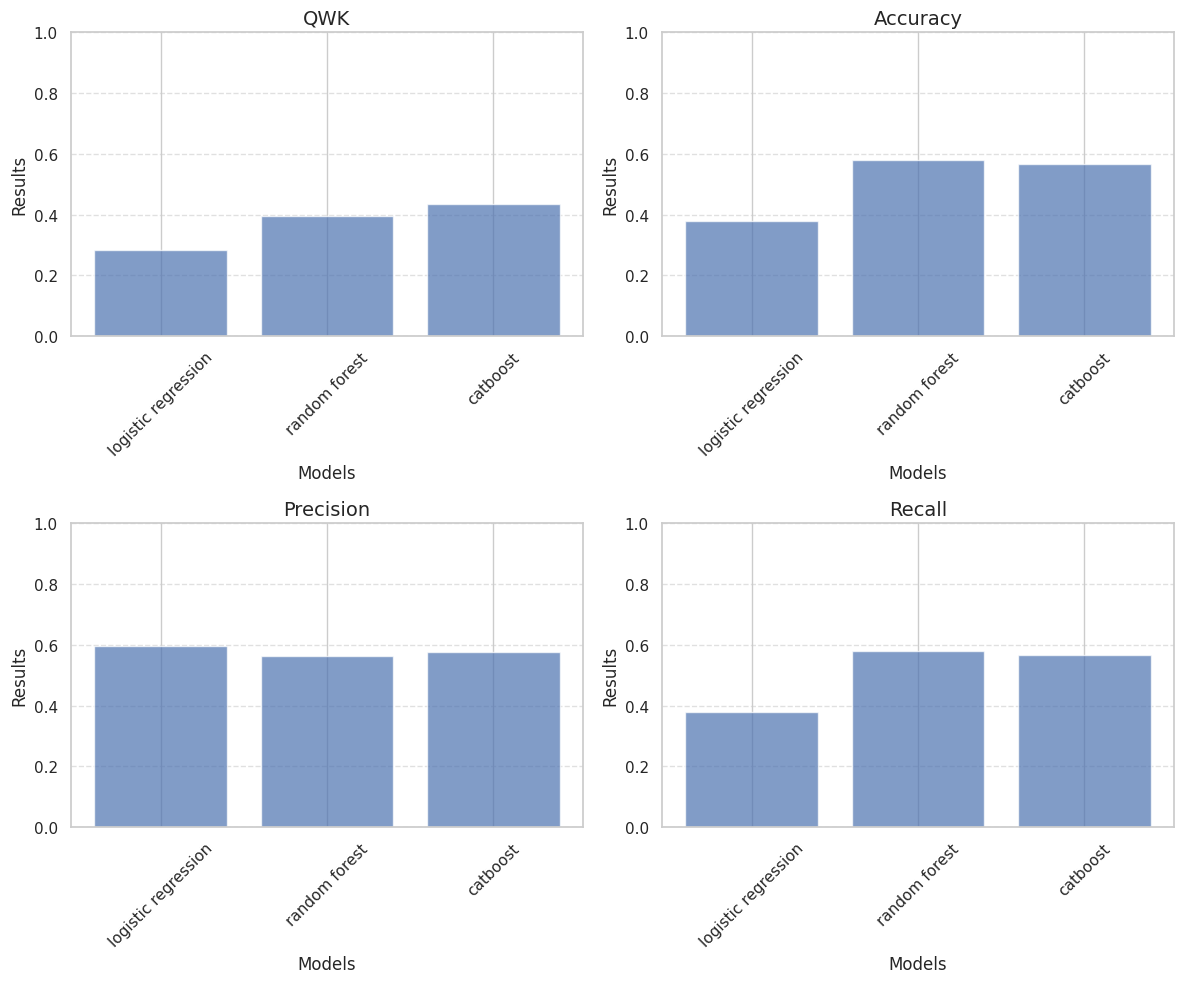

In [13]:
# List of dictionaries and titles
dicts = [results, results_accuracy, results_precision, results_recall]
titles = ['QWK', 'Accuracy', 'Precision', 'Recall']

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot each dictionary in a separate subplot
for i, (ax, data, title) in enumerate(zip(axes, dicts, titles)):
    models = list(data.keys())
    results = [r/5 for r in list(data.values())]
    
    ax.bar(models, results, alpha=0.7)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Models', fontsize=12)
    ax.set_ylabel('Results', fontsize=12)
    ax.set_ylim(0, 1)  # Assuming results are between 0 and 1
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()

# Show the plot
# plt.show()
file_path = 'grid_of_barplots.png'
plt.savefig(file_path, dpi=300)